In [1]:
! pip install pywph==1.0

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import pywph as pw
import numpy as np
import torch
import scipy.optimize as opt
import time

Reason for being yanked: Wrong requirements.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
params = pd.read_csv('drive/MyDrive/camels data/params.csv')
nbody_file = np.load('drive/MyDrive/camels data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy')
mgas_file = np.load('drive/MyDrive/camels data/Maps_Mgas_SIMBA_LH_z=0.00.npy')

In [109]:
full_params = params.loc[params.index.repeat(15)] # from len=1000 to len=15000
full_params = full_params.to_numpy()
#wph_coeffs_cross = np.load('drive/MyDrive/camels data/wph_coeffs_cross.npy')
wph_coeffs_cross_norm = np.load('drive/MyDrive/camels data/wph_coeffs_cross_norm.npy')

Normalised coefficients used in this file (norm='auto')

In [5]:
M = 256
N = 256
J = 7
L = 4
dn =0

nbody_data = np.log(nbody_file)
mgas_data = np.log(mgas_file)
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn)
norm = None

In [ ]:
#np.save('drive/MyDrive/camels data/wph_coeffs_cross.npy', wph_coeffs_1000_cross) #norm = None
#np.save('drive/MyDrive/camels data/wph_coeffs_cross_norm.npy', wph_coeffs_1000_cross_norm) #norm = 'auto'

In [6]:
wph = wph_op([nbody_data[0],mgas_data[0]], pbc=True, cross=True, norm=norm, ret_wph_obj=True)
S11_shape = (wph.get_coeffs("S11")[0].shape)[0]
S00_shape = (wph.get_coeffs("S00")[0].shape)[0]
S01_shape = (wph.get_coeffs("S01")[0].shape)[0]
C01_shape = (wph.get_coeffs("C01")[0].shape)[0]
Cphase_shape = (wph.get_coeffs("Cphase")[0].shape)[0]
L_shape = (wph.get_coeffs("L")[0].shape)[0]


In [110]:
real_coeffs = wph_coeffs_cross_norm.real
imag_coeffs = wph_coeffs_cross_norm.imag
# use real part only here

In [111]:
print(real_coeffs.mean())
print(imag_coeffs.mean())

0.5991867932108781
-0.00015715518311525389


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [11]:
# normalise
scaler = MinMaxScaler()

In [112]:
rescaled_params = np.copy(full_params)
rescaled_params[:,2:] = np.log(rescaled_params[:,2:])
rescaled_params = scaler.fit_transform(rescaled_params)*0.8+0.1

In [113]:
num_samples, num_params= np.shape(rescaled_params)
num_samples, num_coeffs = np.shape(real_coeffs)

coeffs_train, coeffs_test, params_train, params_test = train_test_split((real_coeffs-real_coeffs.mean(axis=0))/(3*real_coeffs.std(axis=0)),
                                                                        rescaled_params,
                                                                        test_size=0.1, random_state=42)

In [54]:
model = keras.Sequential([
   tf.keras.layers.Dense(64, activation='relu', input_shape=(num_coeffs,)),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(10, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   layers.Dense(1, activation='sigmoid'),
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                62016     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
 batch_normalization_2 (Batc  (None, 10)               4

### Omega prediction

In [ ]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.00001)
model.compile(loss='mean_squared_error', optimizer=opt)
train_omega = model.fit(coeffs_train, params_train[:,0], epochs=200, batch_size=50,
                  validation_data=(coeffs_test, params_test[:,0]))

47/47 [==============================] - 0s 2ms/step


Text(0.5, 0, 'number of epochs')

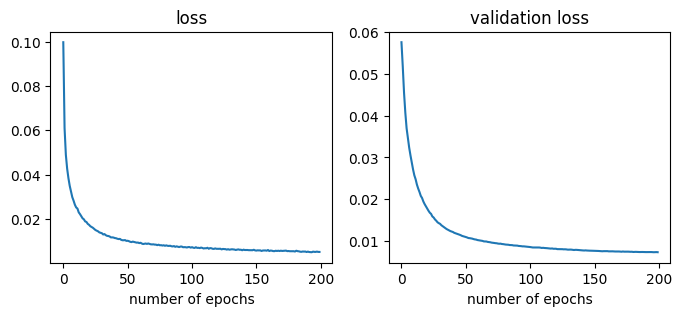

In [56]:
predictions_omega = model.predict(coeffs_test)
loss = train_omega.history['loss']
val_loss = train_omega.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(loss)
axs[1].plot(val_loss)
axs[0].set_title('loss')
axs[1].set_title('validation loss')

axs[0].set_xlabel('number of epochs')
axs[1].set_xlabel('number of epochs')

### Sigma prediction

In [18]:
model = keras.Sequential([
   tf.keras.layers.Dense(64, activation='relu', input_shape=(num_coeffs,)),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(10, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   layers.Dense(1, activation='sigmoid'),
])

In [ ]:
opt = Adam(learning_rate=0.000004)
model.compile(loss='mean_squared_error', optimizer=opt)
train_sigma = model.fit(coeffs_train, params_train[:,1], epochs=600, batch_size=50,
                  validation_data=(coeffs_test, params_test[:,1]))

47/47 [==============================] - 0s 2ms/step


Text(0.5, 0, 'number of epochs')

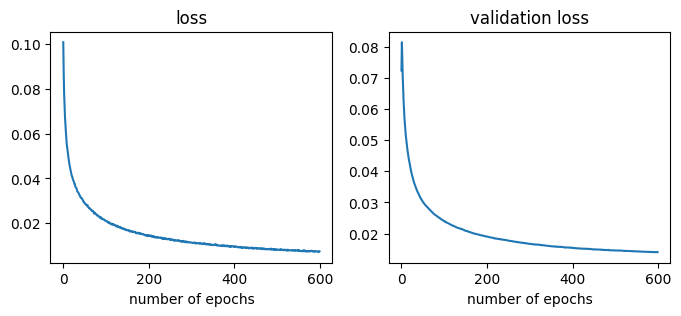

In [20]:
predictions_sigma= model.predict(coeffs_test)
loss = train_sigma.history['loss']
val_loss = train_sigma.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(loss)
axs[1].plot(val_loss)
axs[0].set_title('loss')
axs[1].set_title('validation loss')

axs[0].set_xlabel('number of epochs')
axs[1].set_xlabel('number of epochs')

### SN1 prediction

In [48]:
model = keras.Sequential([
   tf.keras.layers.Dense(64, activation='relu', input_shape=(num_coeffs,)),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(10, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   layers.Dense(1, activation='sigmoid'),
])

In [ ]:
opt = Adam(learning_rate=0.000005)
model.compile(loss='mean_squared_error', optimizer=opt)
train_sn1 = model.fit(coeffs_train, params_train[:,2], epochs=350, batch_size=60,
                      validation_data=(coeffs_test, params_test[:,2]))

47/47 [==============================] - 0s 2ms/step


Text(0.5, 0, 'number of epochs')

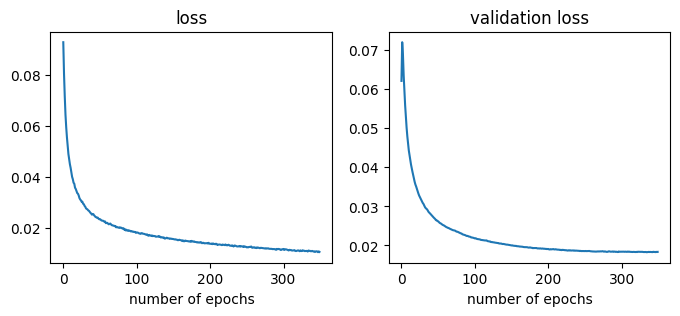

In [50]:
predictions_sn1= model.predict(coeffs_test)
loss = train_sn1.history['loss']
val_loss = train_sn1.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(loss)
axs[1].plot(val_loss)
axs[0].set_title('loss')
axs[1].set_title('validation loss')

axs[0].set_xlabel('number of epochs')
axs[1].set_xlabel('number of epochs')

### SN2 prediction

In [114]:
model = keras.Sequential([
   tf.keras.layers.Dense(64, activation='relu', input_shape=(num_coeffs,)),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(10, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   layers.Dense(1, activation='sigmoid'),
])

In [ ]:
opt = Adam(learning_rate=0.0000009)
model.compile(loss='mean_squared_error', optimizer=opt)
train_sn2 = model.fit(coeffs_train, params_train[:,3], epochs=1500, batch_size=45,
                  validation_data=(coeffs_test, params_test[:,3]))

47/47 [==============================] - 0s 2ms/step


Text(0.5, 0, 'number of epochs')

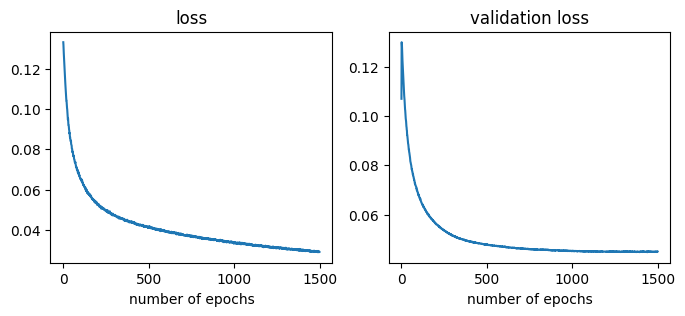

In [116]:
predictions_sn2= model.predict(coeffs_test)
loss = train_sn2.history['loss']
val_loss = train_sn2.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(loss)
axs[1].plot(val_loss)
axs[0].set_title('loss')
axs[1].set_title('validation loss')

axs[0].set_xlabel('number of epochs')
axs[1].set_xlabel('number of epochs')

### AGN1 prediction

In [27]:
model = keras.Sequential([
   tf.keras.layers.Dense(64, activation='relu', input_shape=(num_coeffs,)),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(10, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   layers.Dense(1, activation='sigmoid'),
])

In [ ]:
opt = Adam(learning_rate=0.000002)
model.compile(loss='mean_squared_error', optimizer=opt)
train_agn1 = model.fit(coeffs_train, params_train[:,4], epochs=300, batch_size=60,
                  validation_data=(coeffs_test, params_test[:,4]))

47/47 [==============================] - 0s 2ms/step


Text(0.5, 0, 'number of epochs')

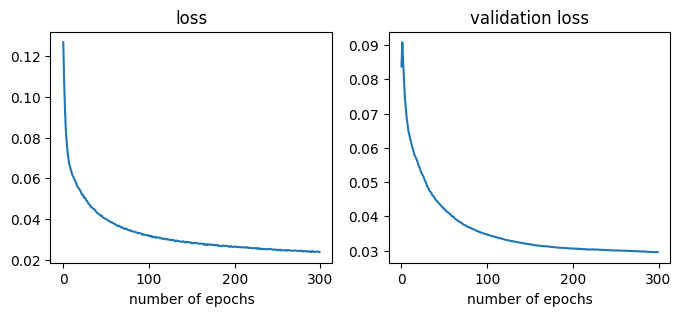

In [29]:
predictions_agn1= model.predict(coeffs_test)
loss = train_agn1.history['loss']
val_loss = train_agn1.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(loss)
axs[1].plot(val_loss)
axs[0].set_title('loss')
axs[1].set_title('validation loss')

axs[0].set_xlabel('number of epochs')
axs[1].set_xlabel('number of epochs')

### AGN2 prediction

In [117]:
model = keras.Sequential([
   tf.keras.layers.Dense(64, activation='relu', input_shape=(num_coeffs,)),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(10, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   layers.Dense(1, activation='sigmoid'),
])

In [ ]:
opt = Adam(learning_rate=0.0000006)
model.compile(loss='mean_squared_error', optimizer=opt)
train_agn2 = model.fit(coeffs_train, params_train[:,5], epochs=1500, batch_size=50,
                  validation_data=(coeffs_test, params_test[:,5]))

47/47 [==============================] - 0s 2ms/step


Text(0.5, 0, 'number of epochs')

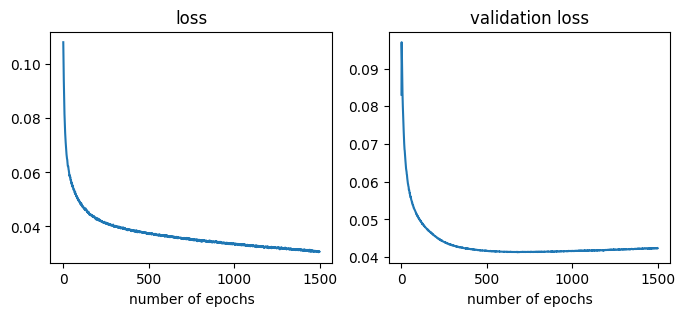

In [119]:
predictions_agn2= model.predict(coeffs_test)
loss = train_agn2.history['loss']
val_loss = train_agn2.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(loss)
axs[1].plot(val_loss)
axs[0].set_title('loss')
axs[1].set_title('validation loss')

axs[0].set_xlabel('number of epochs')
axs[1].set_xlabel('number of epochs')

In [81]:
predictions = np.concatenate([predictions_omega,predictions_sigma,predictions_sn1,predictions_sn2,predictions_agn1,predictions_agn2],axis=1)
pd.DataFrame(predictions)

,0,1,2,3,4,5
0,0.275827,0.227965,0.237527,0.533844,0.519524,0.490786
1,0.823084,0.785185,0.641824,0.510858,0.288502,0.641225
2,0.257154,0.716344,0.291109,0.306860,0.602148,0.695587
3,0.675936,0.313971,0.221411,0.607055,0.673915,0.440419
4,0.186946,0.179652,0.462395,0.561872,0.481045,0.358332
...,...,...,...,...,...,...
1495,0.402557,0.466064,0.392544,0.564186,0.411775,0.447669
1496,0.553077,0.225322,0.757296,0.237769,0.888001,0.384824
1497,0.145158,0.602797,0.205733,0.614062,0.482328,0.576991
1498,0.289776,0.532183,0.268796,0.376111,0.779758,0.440530


In [82]:
pd.DataFrame(params_test)

,0,1,2,3,4,5
0,0.268168,0.187287,0.243344,0.236133,0.115211,0.385883
1,0.631732,0.838338,0.639738,0.300195,0.453951,0.849551
2,0.327427,0.839940,0.365865,0.610110,0.800702,0.578075
3,0.674975,0.288989,0.355455,0.543642,0.654954,0.286587
4,0.168869,0.136036,0.360260,0.710209,0.763063,0.819118
...,...,...,...,...,...,...
1495,0.442743,0.447548,0.501200,0.415514,0.493995,0.287381
1496,0.575676,0.208108,0.779879,0.839139,0.831932,0.718218
1497,0.160060,0.349049,0.140836,0.390690,0.299399,0.467565
1498,0.293794,0.533233,0.136832,0.492389,0.578877,0.535633


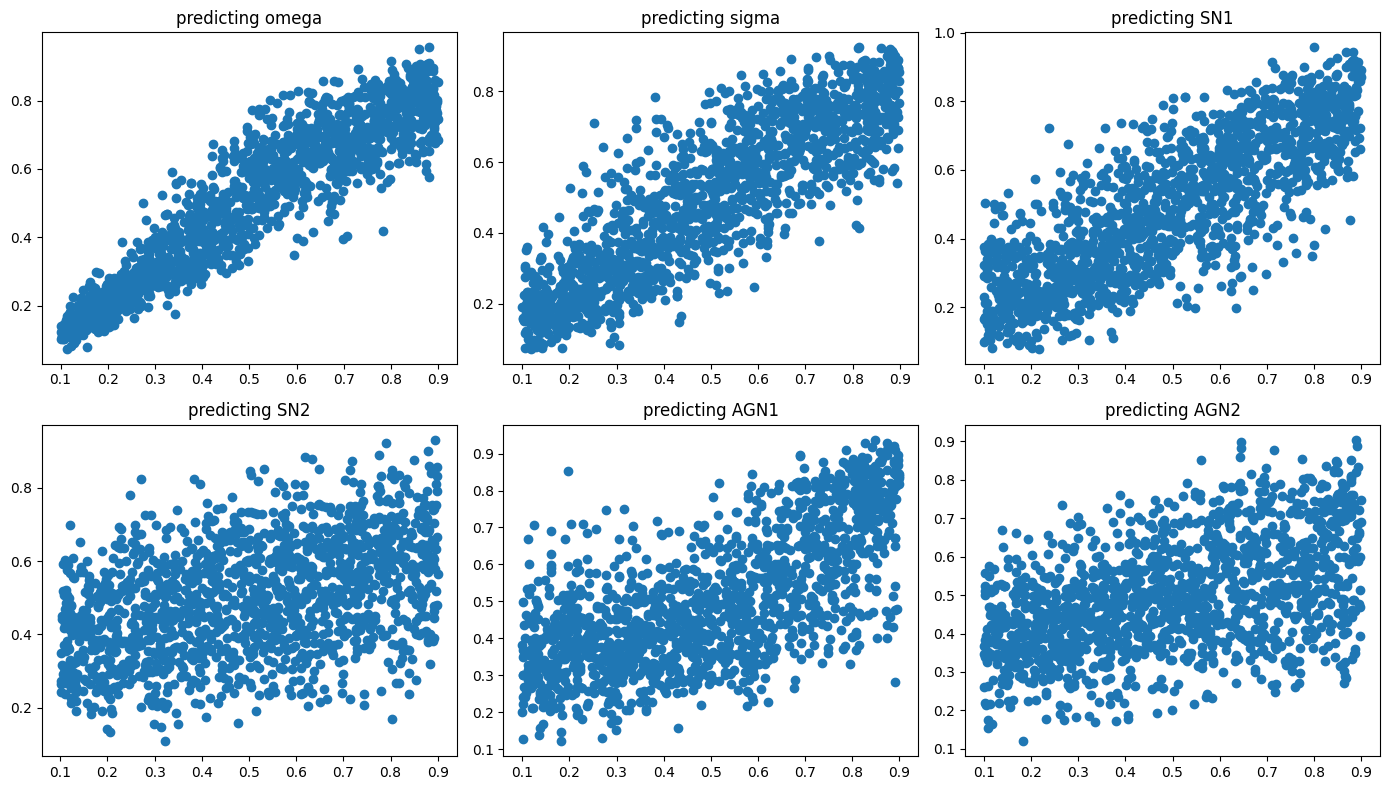

In [83]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
axs[0,0].set_title('predicting omega')
axs[0,1].set_title('predicting sigma')
axs[0,2].set_title('predicting SN1')
axs[1,0].set_title('predicting SN2')
axs[1,1].set_title('predicting AGN1')
axs[1,2].set_title('predicting AGN2')

axs[0,0].scatter(params_test[:,0],predictions_omega)
axs[0,1].scatter(params_test[:,1],predictions_sigma)
axs[0,2].scatter(params_test[:,2],predictions_sn1)
axs[1,0].scatter(params_test[:,3],predictions_sn2)
axs[1,1].scatter(params_test[:,4],predictions_agn1)
axs[1,2].scatter(params_test[:,5],predictions_agn2)

fig.tight_layout()
fig.show()


# remove S11 coefficients

In [84]:
real_coeffs_s11 = np.copy(real_coeffs)
real_coeffs_s11 = real_coeffs_s11[:,S11_shape:]
real_coeffs_s11.shape

(15000, 940)

In [85]:
num_samples, num_params= np.shape(rescaled_params)
num_samples, num_coeffs = np.shape(real_coeffs_s11)

coeffs_train, coeffs_test, params_train, params_test = train_test_split((real_coeffs_s11-real_coeffs_s11.mean(axis=0))/(3*real_coeffs_s11.std(axis=0)),
                                                                        rescaled_params,
                                                                        test_size=0.1, random_state=42)

### Omega prediction

In [86]:
model = keras.Sequential([
   tf.keras.layers.Dense(64, activation='relu', input_shape=(num_coeffs,)),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(10, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   layers.Dense(1, activation='sigmoid'),
])

In [ ]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.00001)
model.compile(loss='mean_squared_error', optimizer=opt)
train_omega = model.fit(coeffs_train, params_train[:,0], epochs=200, batch_size=50,
                  validation_data=(coeffs_test, params_test[:,0]))

47/47 [==============================] - 0s 2ms/step


Text(0.5, 0, 'number of epochs')

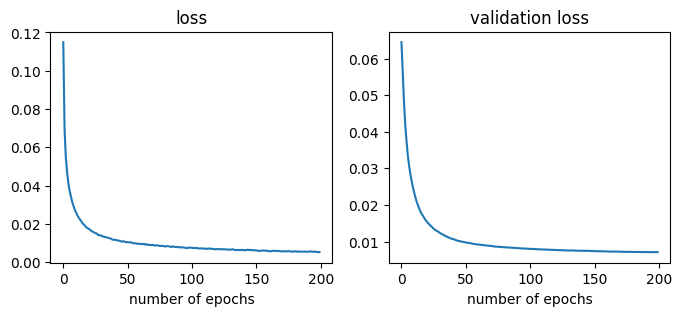

In [88]:
predictions_omega = model.predict(coeffs_test)
loss = train_omega.history['loss']
val_loss = train_omega.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(loss)
axs[1].plot(val_loss)
axs[0].set_title('loss')
axs[1].set_title('validation loss')

axs[0].set_xlabel('number of epochs')
axs[1].set_xlabel('number of epochs')

### Sigma prediction

In [89]:
model = keras.Sequential([
   tf.keras.layers.Dense(64, activation='relu', input_shape=(num_coeffs,)),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(10, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   layers.Dense(1, activation='sigmoid'),
])

In [ ]:
opt = Adam(learning_rate=0.000004)
model.compile(loss='mean_squared_error', optimizer=opt)
train_sigma = model.fit(coeffs_train, params_train[:,1], epochs=600, batch_size=50,
                  validation_data=(coeffs_test, params_test[:,1]))

47/47 [==============================] - 0s 2ms/step


Text(0.5, 0, 'number of epochs')

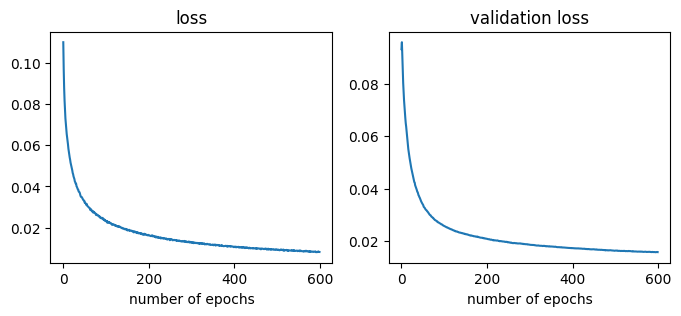

In [91]:
predictions_sigma= model.predict(coeffs_test)
loss = train_sigma.history['loss']
val_loss = train_sigma.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(loss)
axs[1].plot(val_loss)
axs[0].set_title('loss')
axs[1].set_title('validation loss')

axs[0].set_xlabel('number of epochs')
axs[1].set_xlabel('number of epochs')

### SN1 prediction

In [92]:
model = keras.Sequential([
   tf.keras.layers.Dense(64, activation='relu', input_shape=(num_coeffs,)),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(10, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   layers.Dense(1, activation='sigmoid'),
])

In [ ]:
opt = Adam(learning_rate=0.000005)
model.compile(loss='mean_squared_error', optimizer=opt)
train_sn1 = model.fit(coeffs_train, params_train[:,2], epochs=450, batch_size=60,
                      validation_data=(coeffs_test, params_test[:,2]))

47/47 [==============================] - 0s 2ms/step


Text(0.5, 0, 'number of epochs')

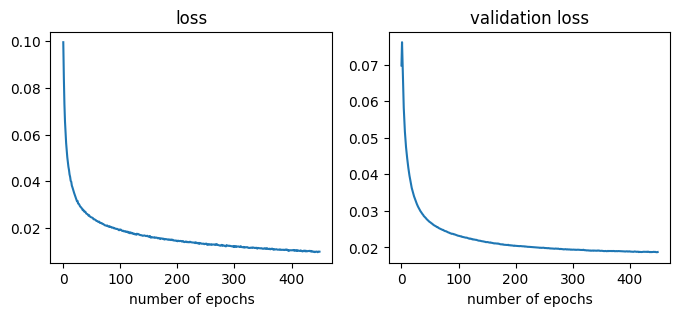

In [94]:
predictions_sn1= model.predict(coeffs_test)
loss = train_sn1.history['loss']
val_loss = train_sn1.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(loss)
axs[1].plot(val_loss)
axs[0].set_title('loss')
axs[1].set_title('validation loss')

axs[0].set_xlabel('number of epochs')
axs[1].set_xlabel('number of epochs')

### SN2 prediction

In [104]:
model = keras.Sequential([
   tf.keras.layers.Dense(64, activation='relu', input_shape=(num_coeffs,)),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(10, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   layers.Dense(1, activation='sigmoid'),
])

In [ ]:
opt = Adam(learning_rate=0.000001)
model.compile(loss='mean_squared_error', optimizer=opt)
train_sn2 = model.fit(coeffs_train, params_train[:,3], epochs=1500, batch_size=45,
                  validation_data=(coeffs_test, params_test[:,3]))

47/47 [==============================] - 0s 2ms/step


Text(0.5, 0, 'number of epochs')

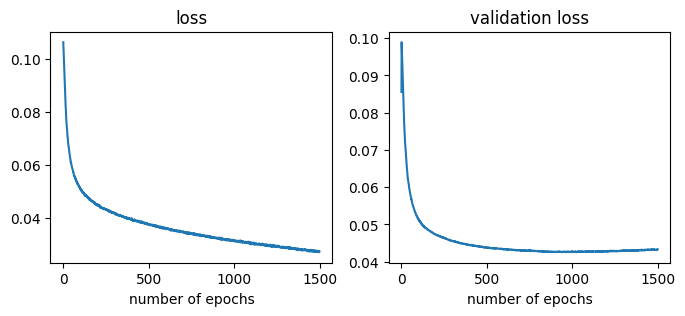

In [106]:
predictions_sn2= model.predict(coeffs_test)
loss = train_sn2.history['loss']
val_loss = train_sn2.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(loss)
axs[1].plot(val_loss)
axs[0].set_title('loss')
axs[1].set_title('validation loss')

axs[0].set_xlabel('number of epochs')
axs[1].set_xlabel('number of epochs')

### AGN1 prediction


In [98]:
model = keras.Sequential([
   tf.keras.layers.Dense(64, activation='relu', input_shape=(num_coeffs,)),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(10, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   layers.Dense(1, activation='sigmoid'),
])

In [ ]:
opt = Adam(learning_rate=0.000002)
model.compile(loss='mean_squared_error', optimizer=opt)
train_agn1 = model.fit(coeffs_train, params_train[:,4], epochs=350, batch_size=60,
                  validation_data=(coeffs_test, params_test[:,4]))

47/47 [==============================] - 0s 2ms/step


Text(0.5, 0, 'number of epochs')

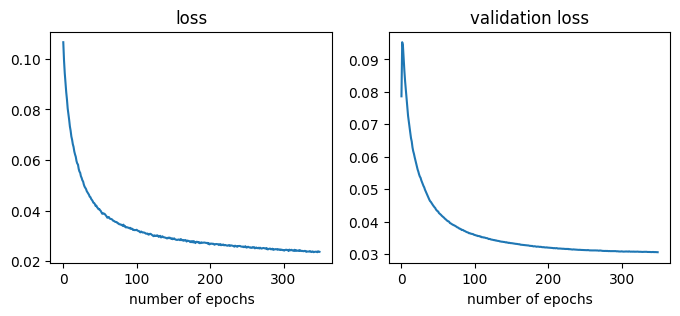

In [100]:
predictions_agn1= model.predict(coeffs_test)
loss = train_agn1.history['loss']
val_loss = train_agn1.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(loss)
axs[1].plot(val_loss)
axs[0].set_title('loss')
axs[1].set_title('validation loss')

axs[0].set_xlabel('number of epochs')
axs[1].set_xlabel('number of epochs')

### AGN2 prediction


In [101]:
model = keras.Sequential([
   tf.keras.layers.Dense(64, activation='relu', input_shape=(num_coeffs,)),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(32, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(10, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   layers.Dense(1, activation='sigmoid'),
])

In [ ]:
opt = Adam(learning_rate=0.0000008)
model.compile(loss='mean_squared_error', optimizer=opt)
train_agn2 = model.fit(coeffs_train, params_train[:,5], epochs=1000, batch_size=50,
                  validation_data=(coeffs_test, params_test[:,5]))

47/47 [==============================] - 0s 2ms/step


Text(0.5, 0, 'number of epochs')

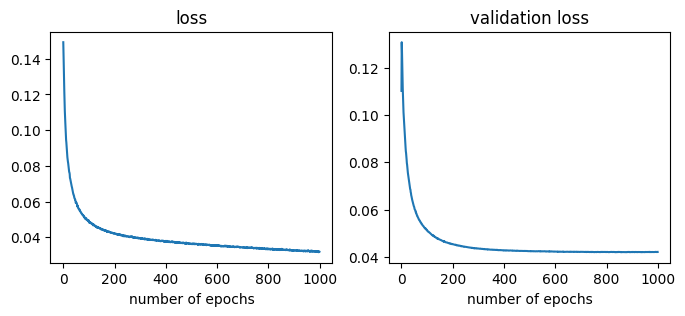

In [103]:
predictions_agn2= model.predict(coeffs_test)
loss = train_agn2.history['loss']
val_loss = train_agn2.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(loss)
axs[1].plot(val_loss)
axs[0].set_title('loss')
axs[1].set_title('validation loss')

axs[0].set_xlabel('number of epochs')
axs[1].set_xlabel('number of epochs')

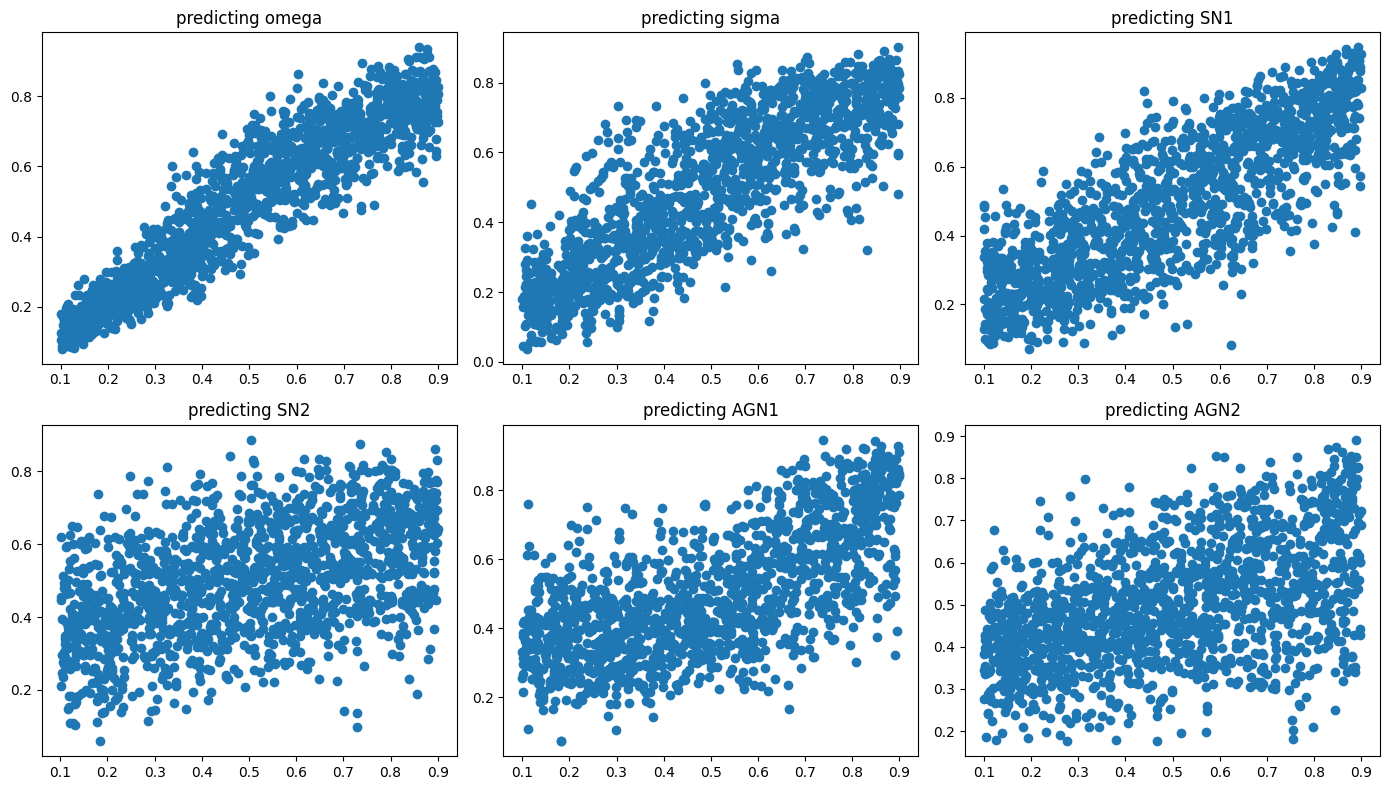

In [107]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
axs[0,0].set_title('predicting omega')
axs[0,1].set_title('predicting sigma')
axs[0,2].set_title('predicting SN1')
axs[1,0].set_title('predicting SN2')
axs[1,1].set_title('predicting AGN1')
axs[1,2].set_title('predicting AGN2')

axs[0,0].scatter(params_test[:,0],predictions_omega)
axs[0,1].scatter(params_test[:,1],predictions_sigma)
axs[0,2].scatter(params_test[:,2],predictions_sn1)
axs[1,0].scatter(params_test[:,3],predictions_sn2)
axs[1,1].scatter(params_test[:,4],predictions_agn1)
axs[1,2].scatter(params_test[:,5],predictions_agn2)

fig.tight_layout()
fig.show()
